In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import PytorchModel

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
import subprocess

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals

In [2]:
torch.manual_seed(0)
random.seed(0)

In [3]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0     10      0 --:--:-- --:--:-- --:--:--     0
100 4031k  100 4031k    0     0  3018k      0  0:00:01  0:00:01 --:--:-- 3018k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

In [13]:
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
specky_table.head(3)

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song


In [14]:
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]
specky_table.woodcock.values

array(['present', 'absent', 'present', 'present', 'present', 'absent',
       'present', 'absent', 'present', 'present', 'present', 'absent',
       'present', 'present', 'present', 'absent', 'present', 'present',
       'present', 'present', 'present', 'present', 'present', 'present',
       'absent', 'absent', 'present', 'present', 'present'], dtype=object)

In [15]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(specky_table[['woodcock']].values)

In [16]:
one_hot_labels

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1]])

In [17]:
classes

['absent', 'present']

In [18]:
labels = pd.DataFrame(index=specky_table['filename'],data=one_hot_labels,columns=classes)
labels.head()

,absent,present
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


In [19]:
type(labels)

pandas.core.frame.DataFrame

In [20]:
from sklearn.model_selection import train_test_split
train_df,valid_df = train_test_split(labels,test_size=0.2,random_state=1)

In [23]:
valid_df.shape

(6, 2)

Each Preprocessor must be initialized with a very specific dataframe with the following attributes:

- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

Advantages of OpSo
- one of the main advantages of opso: extensive preprocessing for audio files
- and it returns it as a pytorch tensor, so can build custom networks and train paradigms

In [25]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor
train_dataset = CnnPreprocessor(train_df)
valid_dataset = CnnPreprocessor(valid_df)

## Inspect training images

In [27]:
# helper function for displaying a sample as an image
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

labels: tensor([0, 1])


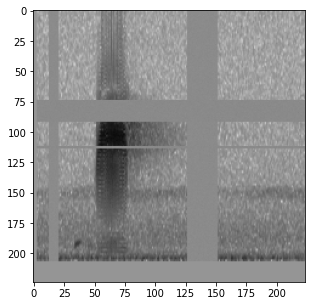

labels: tensor([0, 1])


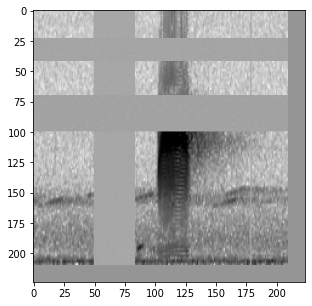

labels: tensor([0, 1])


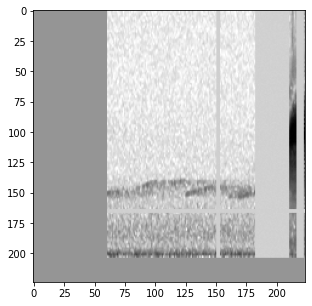

labels: tensor([0, 1])


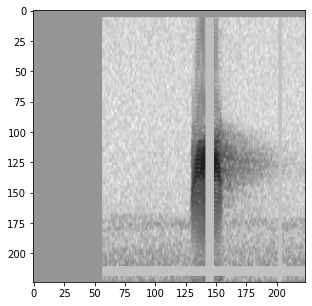

In [28]:
for i, d in enumerate(train_dataset.sample(n=4)):
    print(f"labels: {d['y']}")
    show_tensor(d)

labels: tensor([0, 1])


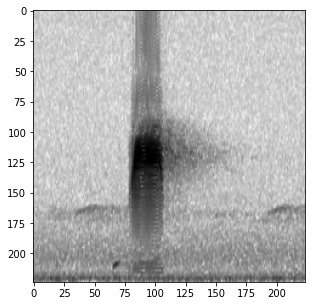

labels: tensor([1, 0])


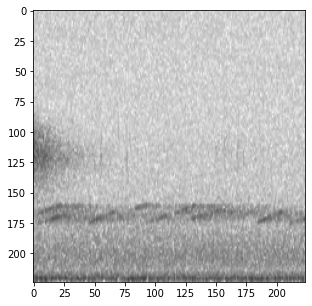

labels: tensor([1, 0])


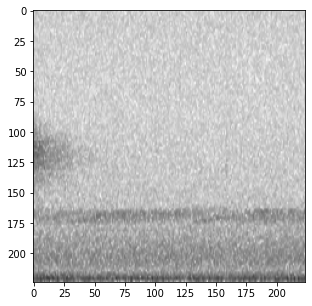

labels: tensor([0, 1])


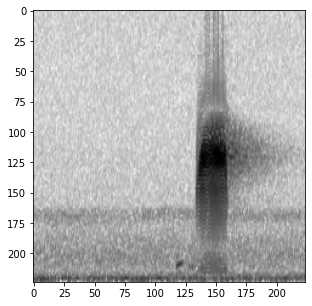

In [29]:
train_dataset.augmentation_off()
for i, d in enumerate(train_dataset.sample(n=4)):
    print(f"labels: {d['y']}")
    show_tensor(d)
#turn augmentation back on when we're done
train_dataset.augmentation_on()

## Training

In [30]:
train_df.columns

Index(['absent', 'present'], dtype='object')

In [31]:
# Create model object
classes = train_df.columns
model = PytorchModel('resnet18',classes,single_target=True)

created PytorchModel model object with 2 classes


In [37]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./binary_train/',
    epochs=10,
    batch_size=64,
    save_interval=100,
    num_workers=0,
)

Epoch: 0 [batch 0/1 (0.00%)] 
	Jacc: 0.130 Hamm: 0.739 DistLoss: 0.967

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Updating best model
Epoch: 1 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 0.705

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 2 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 0.771

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 3 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 0.882

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 4 [batch 0/1 (0.00%)] 
	Jacc: 0.524 Hamm: 0.217 DistLoss: 0.430

Validation.
(6, 2)
	 Precision: 0.6666666666666666
	 Recall: 0.8
	 F1: 0.625
Updating best model
Epoch: 5 [batch 0/1 (0.00%)] 
	Jacc: 0.429 Hamm: 0.391 DistLoss: 0.741

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545

Text(0, 0.5, 'loss')

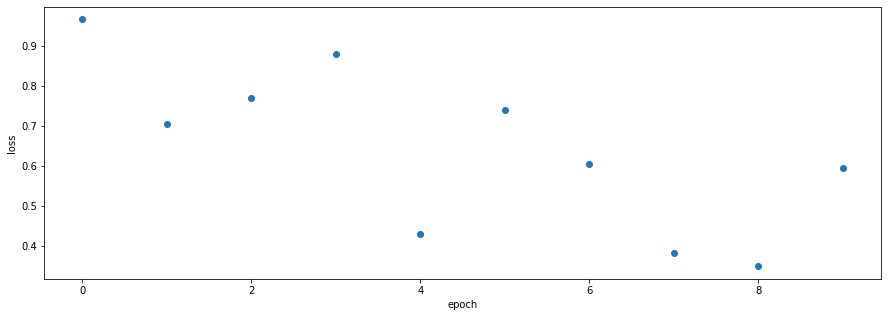

In [38]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [40]:
model.save('example.model')

In [45]:
#create a copy of the training dataset, sampling 0 of the training samples from it
prediction_dataset = model.train_dataset.sample(n=0)
#turn off augmentation on this dataset
prediction_dataset.augmentation_off()
#use the validation samples as test samples for the sake of illustration
prediction_dataset.df = valid_df

`predict` will return three dataframes:

- scores : numeric predictions from the model for each sample and class (by default these are raw outputs from the model)
- predictions: 0/1 predictions from the model for each sample and class (only generated if binary_predictions argument is supplied)
- labels: Original labels from the dataset, if available


In [46]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset)
valid_scores_df.head()

(6, 2)


,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,-3.753400,2.851401
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,-2.813975,2.008137
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,-3.548611,3.171667
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,-4.744555,3.279661
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,-1.129454,-0.279738


In [48]:
valid_labels_df.head()

,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0,1
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0,1
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0,1
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0,1
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,1,0


In [49]:
#multi_target example. doesn't assume classes are mutually exclusive

score_df, pred_df, label_df = model.predict(
    prediction_dataset,
    binary_preds='multi_target',
    threshold=0.99,
)
pred_df.head()

(6, 2)


,absent,present
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,0.0,0.0
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,0.0,0.0
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,0.0,0.0
./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav,0.0,0.0
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,0.0,0.0


## Multi-class models

In [50]:
from opensoundscape.torch.models.cnn import CnnResampleLoss
model = CnnResampleLoss('resnet18',classes)
print("model.single_target:", model.single_target)

created PytorchModel model object with 2 classes
model.single_target: False


In [51]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./multilabel_train/',
    epochs=10,
    batch_size=64,
    save_interval=100,
    num_workers=0
)

Epoch: 0 [batch 0/1 (0.00%)] 
	Jacc: 0.500 Hamm: 0.500 DistLoss: 24.045

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Updating best model
Epoch: 1 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 22.087

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 2 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 23.746

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 3 [batch 0/1 (0.00%)] 
	Jacc: 0.370 Hamm: 0.261 DistLoss: 14.372

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 4 [batch 0/1 (0.00%)] 
	Jacc: 0.651 Hamm: 0.196 DistLoss: 12.731

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Epoch: 5 [batch 0/1 (0.00%)] 
	Jacc: 0.750 Hamm: 0.130 DistLoss: 10.515

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545

In [52]:
train_preds,_,_ = model.predict(train_dataset)
train_preds.columns = ['pred_negative','pred_positive']
train_dataset.df.join(train_preds).head()

(23, 2)


,absent,present,pred_negative,pred_positive
filename,,,,
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1,-6028.577148,3505.933350
./woodcock_labeled_data/ad90eefb6196ca83f9cf43b6f56c4b4a.wav,0,1,-2467.470459,1438.325562
./woodcock_labeled_data/e9e7153d11de3ac8fc3f7164d43bac92.wav,0,1,-6510.780273,3829.539795
./woodcock_labeled_data/c057a4486b25cd638850fc07399385b2.wav,0,1,-11121.533203,6469.854980
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1,-8735.935547,5078.876953


OpenSoundscape saves models automatically during training:

- The model saves weights to self.save_path to epoch-X.model automatically during training every save_interval epochs
- The model keeps the file best.model updated with the weights that achieve the best F1 score on the validation dataset

In [53]:
model1 = PytorchModel('resnet18',classes,single_target=True)
# Save every 2 epochs
model1.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    epochs=3,
    batch_size=8,
    save_path='./binary_train/',
    save_interval=2,
    num_workers=0
)
model1.save('./binary_train/my_favorite.model')

created PytorchModel model object with 2 classes
Epoch: 0 [batch 0/3 (0.00%)] 
	Jacc: 0.125 Hamm: 0.750 DistLoss: 1.039

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Updating best model
Epoch: 1 [batch 0/3 (0.00%)] 
	Jacc: 0.312 Hamm: 0.375 DistLoss: 1.448

Validation.
(6, 2)
	 Precision: 0.6666666666666666
	 Recall: 0.8
	 F1: 0.625
Saving weights, metrics, and train/valid scores.
Updating best model
Epoch: 2 [batch 0/3 (0.00%)] 
	Jacc: 0.411 Hamm: 0.375 DistLoss: 0.762

Validation.
(6, 2)
	 Precision: 0.4166666666666667
	 Recall: 0.5
	 F1: 0.45454545454545453
Saving weights, metrics, and train/valid scores.

Best Model Appears at Epoch 1 with F1 0.625.


In [54]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('./binary_train/best.model')

In [55]:
# load the saved model
model = load_model('./binary_train/best.model')

# create a Preprocessor instance with the audio samples
# use the model.train_dataset as a starting point to ensure that our preprocessing matches what the model expects
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = valid_df

#predict on a dataset
scores,_,_ = model.predict(prediction_dataset, activation_layer='softmax_and_logit')

(6, 2)


In [56]:
import shutil
dirs = ['./multilabel_train', './binary_train', './woodcock_labeled_data']
[shutil.rmtree(d) for d in dirs]

[None, None, None]